# Basic Setup

Set up Basic Parameter here

In [42]:
import numpy as np
import random
from mv_laplace import MvLaplaceSampler
import matplotlib.pyplot as plt
import pandas as pd


In [43]:
# Define sample size
N = 20000 # number of subjects
N_T = 10000 # number of treated subjects

# Define betas
beta_11 = 2
beta_12 = 2
beta_21 = 2
beta_22 = 2
beta_23 = 2
beta_31 = 2


#Mask rate - (30%-50%)
lambda1 = 100
lambda2 = 25
lambda3 = 12

#Define strata size
N_S = 100


# Simulate X
The observed covariates for the $n$-th subject $(X_{n1}, X_{n2}, X_{n3}, X_{n4}, X_{n5})$ are i.i.d. generated through the following process: 


$    (X_{n1}, X_{n2})\sim \mathcal{N}\left[\left(\begin{array}{c}
\frac{1}{2}\\
-\frac{1}{3}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{2} \\
\frac{1}{2} & 1 
\end{array}\right)\right], (X_{n3}, X_{n4})\sim \text{Laplace}\left[\left(\begin{array}{c}
0\\
\frac{1}{\sqrt{3}}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & 1 
\end{array}\right)\right],
$
$X_{n5} \sim \text{Bernoulli}(1/3)$, for $n=1,\dots, N$



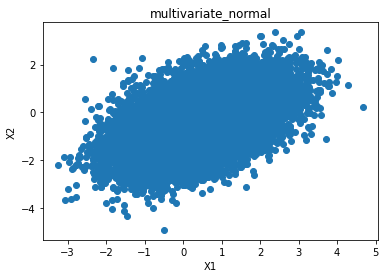

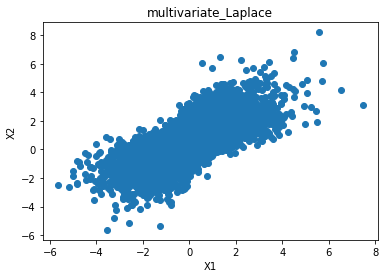

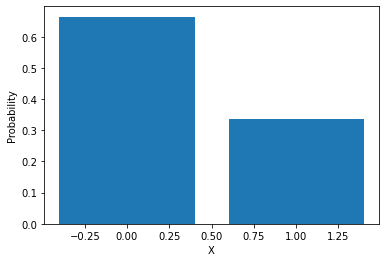

[[ 0.73355135  1.09340215 -0.98893368 -0.02847009  0.        ]
 [-0.03210854 -1.08410586 -0.33065891 -1.51629965  0.        ]
 [ 0.16240225 -1.21118168  0.54813076  0.42122513  1.        ]
 ...
 [ 0.38585942 -1.04648071 -0.78461756 -0.85119718  0.        ]
 [-0.39233816 -1.41172604 -0.87011399  0.47888001  0.        ]
 [ 0.78241594 -0.36025476 -0.06015235  0.10178631  0.        ]]


In [44]:
# generate Xn1 and Xn2
mean = [1/2, -1/3]
cov = [[1, 1/2], [1/2, 1]]
X1_2 = np.random.multivariate_normal(mean, cov, N)
plt.scatter(X1_2[:, 0], X1_2[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_normal")
plt.show()

# generate Xn3 and Xn4
loc = [0, 1/np.sqrt(3)]
cov = [[1,1/np.sqrt(2)], [1/np.sqrt(2),1]]

sampler = MvLaplaceSampler(loc, cov)
X3_4 = sampler.sample(N)
plt.scatter(X3_4[:, 0], X3_4[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_Laplace")
plt.show()

# generate Xn5
p = 1/3
X5 = np.random.binomial(1, p, N)

counts = np.unique(X5, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('X')
plt.ylabel('Probability')
plt.show()

# combine all generated variables into a single matrix
X = np.hstack((X1_2, X3_4, X5.reshape(-1,1)))

print(X)

# Simulate U

The unobserved covariates for the $n$-th subject $(U_{n1}, U_{n2})$ are i.i.d. generated through the following process: $U_{n1}\sim N(1/2, 1)$ and $U_{n2}\sim \text{Bernoulli}(2/3)$, for $n=1,\dots, N$.

In [45]:
# generate Un1
mean = 1/2
std = 1
U_n1 = np.random.normal(mean, std, N)

# generate Un2
U_n2 = np.random.binomial(1, 2/3, N)

U = np.concatenate((U_n1.reshape(-1, 1), U_n2.reshape(-1, 1)), axis=1)

print(U.shape)
print(U_n1.shape, U_n2.shape)
print(U[:,0].shape, U[:,1].shape)


(20000, 2)
(20000,) (20000,)
(20000,) (20000,)


# Simulate S

S is the strata index, range from 1 to N_S(how many strata we indicate), each strata has groupSize = int(N / N_S)

In [46]:
# Add strata index
groupSize = int(N / N_S)
S = np.zeros(N)
for i in range(N_S):
    S[groupSize*i:groupSize*(i+1)] = i + 1
S = S.reshape(-1, 1)
display(pd.DataFrame(S))

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
19995,100.0
19996,100.0
19997,100.0
19998,100.0


# Simulate Z
   In a stratified randomized experiment, the treatment assignments are random within
each stratum 
$ P(\mathbf{Z}=\mathbf{z}\mid \mathcal{Z})=\prod_{i=1}^{I}{J \choose J_{T}}^{-1}, \quad \forall \mathbf{z}\in \mathcal{Z}.$

In [47]:
Z = []
np.random.shuffle(Z)
groupSize = int(N / N_S)

for i in range(N_S):
    Z.append(np.random.binomial(1, 0.5, groupSize))

Z = np.concatenate(Z).reshape(-1, 1)
print(pd.DataFrame(Z).describe())

                  0
count  20000.000000
mean       0.501350
std        0.500011
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000


# Simulate Y

The three outcomes of interest $(Y_{n1}, Y_{n2}, Y_{n3})$ are generated via the following process (for $n=1,\dots, N$):

\begin{align*}
    
    &Y_{n1}= \beta_{11} Z_{n}+\beta_{12}Z_{n}\cdot \sum_{p=1}^{5}\sqrt{p}\cdot \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin(U_{n1})+U_{n2},\\
    &Y_{n2}= \beta_{21} Z_{n} + \beta_{22}Z_{n} X_{n1}+ \beta_{23}Z_{n} U_{n1}U_{n2}+\sum_{p=1}^{5}(\cos{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}\cdot \exp(X_{np^{\prime}}),  \\
    &Y_{n3}= \beta_{31} Z_{n} + \sum_{p=1}^{5}(\sin{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}\exp(X_{np^{\prime\prime}})+X_{n1} X_{n2}\cdot \sin (U_{n1}U_{n2}).
   
\end{align*}
    

In [48]:

#def sum1():
sum1 = np.zeros(N)
for p in range(1,6):
  sum1 += np.sqrt(p) * np.exp(X[:,p-1])

#def sum2():
sum2 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum2 += X[:,p-1] * np.power(X[:,p_2-1],2)

#def sum3():
sum3 = np.zeros(N)

for p in range(1,6):
  sum3 += np.cos(p) * X[:,p-1]

#def sum4():
sum4 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum4 += X[:,p-1] * np.exp(X[:,p_2-1])

#def sum5():
sum5 = np.zeros(N)
for p in range(1,6):
  sum5 += np.sin(p) * X[:,p-1]

#def sum6(): 
sum6 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    for p_3 in range(1,6):
      sum6 += X[:,p-1] * X[:,p_2-1] * np.exp(X[:,p_3-1])

Z_New = Z.reshape(-1, )

# Calculate Y_n1
Y_n1 = (beta_11 * Z_New + beta_12 * Z_New * sum1   + sum2 + np.sin(U_n1) + U_n2) 

# Compute Yn2
Y_n2 = (beta_21 * Z_New + beta_22 * Z_New * X[:,0] + beta_23 * Z_New * U_n1 * U_n2 + sum3 + sum4) 

# Compute Yn3
Y_n3 = (beta_31 * Z_New + sum5 + sum6 + X[:,0] * X[:,1] * np.sin(U_n1 * U_n2)) 

Y = np.concatenate((Y_n1.reshape(-1, 1), Y_n2.reshape(-1, 1),Y_n3.reshape(-1, 1)), axis=1) 
print(Y.shape)

(20000, 3)


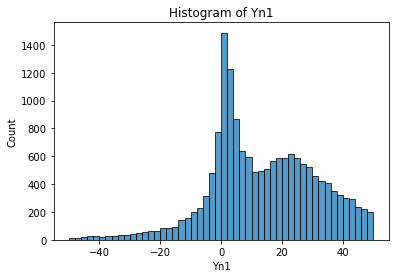

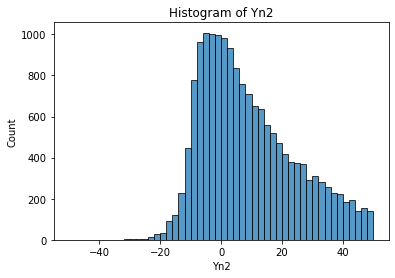

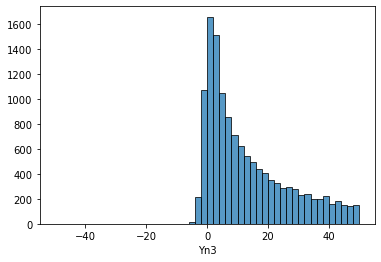

In [49]:
# Plot histogram of Yn1
plt.hist(Y_n1, bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Yn2
plt.hist(Y_n2, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Yn3
plt.hist(Y_n3, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn3')
plt.show()

#Simulate M

\begin{align*}
            &M_{n1}=\mathbf{1}\Big \{\sum_{p=1}^{5} \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin^{3}(U_{n1})+U_{n2} + \exp(Y_{n1})> \lambda_{1} \} \\
            &M_{n2}=\mathbf{1}\Big \{\sum_{p=1}^{5} X_{np}^{3}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}X_{np^{\prime}}+U_{n1}+ \frac{1}{2}\cdot Y_{n1}^{3}+Y_{n2}>\lambda_{2} \} \\
            &  M_{n3}=\mathbf{1}\Big \{\sum_{p=1}^{5}p\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}X_{np^{\prime\prime}}+\sin(U_{n1})\cdot U_{n2} + Y_{n1} + \exp(Y_{n2}) > \lambda_{3} \}. 
\end{align*}






In [50]:
maskrate = 0.3

def missing_dataset_indicator(X, U, Y, lambda1, lambda2, lambda3, single = True):
    n = X.shape[0]
    M = np.zeros((n, 3))
    M_lamda = np.zeros((n, 3))

    for i in range(n):
        sum1 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum1 += X[i,p-1] * np.power(X[i,p_2-1],2)
          
        sum2 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum2 += X[i,p-1] * X[i,p_2-1]

        sum3 = 0
        for p in range(1,6):
            sum3 += p * X[i,p-1] 

        sum4 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            for p_3 in range(1,6):
              sum4 += X[i,p-1] * X[i,p_2-1] * X[i,p_3-1]

        M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])

        M_lamda[i][1] = ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1])

        M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))

    
    # calculate 1 - Maskrate percentile
    lambda1 = np.percentile(M_lamda[:,0], 100 * (1-maskrate))
    lambda2 = np.percentile(M_lamda[:,1], 100 * (1-maskrate))
    lambda3 = np.percentile(M_lamda[:,2], 100 * (1-maskrate))
        
    for i in range(N):
        if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:
          M[i][0] = 1 - single
        else:
          M[i][0] = 0
        
        if ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1]) > lambda2:
          M[i][1] =  1 - single
        else:
          M[i][1] =  0

        if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
          M[i][2] =  1
        else:
          M[i][2] =  0

    return M,M_lamda

M,M_lamda = missing_dataset_indicator(X,U,Y,lambda1,lambda2,lambda3)
display(pd.DataFrame(M))
print(M_lamda)


<ipython-input-50-d1ae7282fadf>:29: RuntimeWarning: overflow encountered in exp
  M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])
<ipython-input-50-d1ae7282fadf>:33: RuntimeWarning: overflow encountered in exp
  M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))
<ipython-input-50-d1ae7282fadf>:42: RuntimeWarning: overflow encountered in exp
  if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:
<ipython-input-50-d1ae7282fadf>:52: RuntimeWarning: overflow encountered in exp
  if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:


,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,1.0
19996,0.0,0.0,0.0
19997,0.0,0.0,0.0
19998,0.0,0.0,0.0


[[ 2.01322563e+12  1.13846116e+04  2.84625836e+05]
 [-5.60958922e+00 -3.32724364e+02 -4.30657468e+01]
 [ 6.51305456e+14  1.98565329e+04  1.15080316e+05]
 ...
 [ 3.20721024e+03  2.62797875e+02 -1.14791458e+01]
 [-2.92066125e+00 -1.57617490e+02 -2.12055204e+01]
 [ 4.42269649e+09  5.48653602e+03  2.01799452e+03]]


[ 2.01322563e+12 -5.60958922e+00  6.51305456e+14 ...  3.20721024e+03
 -2.92066125e+00  4.42269649e+09]
[2.01322563e+12 1.13846116e+04 2.84625836e+05]


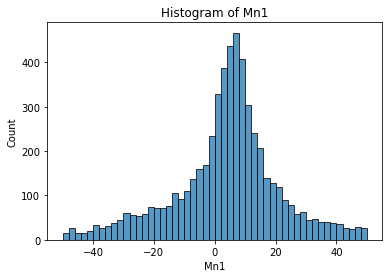

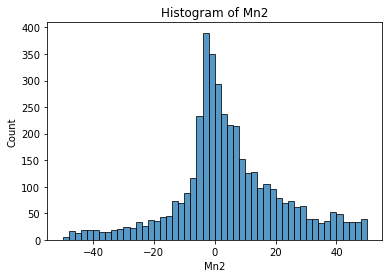

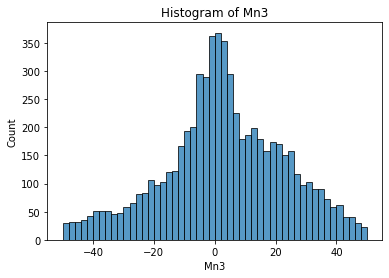

In [51]:
# Plot histogram of Mn1
print(M_lamda[:,0])
print(M_lamda[0,:])

plt.hist(M_lamda[:,0], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn1')
plt.ylabel('Count')
plt.title('Histogram of Mn1')
plt.show()

# Plot histogram of Mn2
plt.hist(M_lamda[:,1], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn2')
plt.ylabel('Count')
plt.title('Histogram of Mn2')
plt.show()

# Plot histogram of Mn3
plt.hist(M_lamda[:,2], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn3')
plt.ylabel('Count')
plt.title('Histogram of Mn3')
plt.show()

In [52]:
print(M[:,0].sum() / N)

print(M[:,1].sum() / N)

print(M[:,2].sum() / N)

0.0
0.0
0.3


# Demonstate the Dataframe


In [53]:
Y_masked = np.ma.masked_array(Y, mask=M)
Y_masked = Y_masked.filled(np.nan)
df = pd.DataFrame(np.concatenate((Z, X, Y_masked,S), axis=1))
df.columns = ['Z', 'X1', 'X2', 'X3', 'X4', 'X5', 'Y1', 'Y2', 'Y3', 'S']
display(df)
df.to_csv('Sample_data.csv', index=False)
df.describe()

,Z,X1,X2,X3,X4,X5,Y1,Y2,Y3,S
0,1.0,0.733551,1.093402,-0.988934,-0.028470,0.0,28.330759,12.558827,9.056415,1.0
1,0.0,-0.032109,-1.084106,-0.330659,-1.516300,0.0,-8.706621,-7.861979,28.608639,1.0
2,1.0,0.162402,-1.211182,0.548131,0.421225,1.0,34.110000,11.653021,5.961538,1.0
3,1.0,1.688071,0.037959,-0.781422,-0.263678,1.0,41.887719,26.521297,NaN,1.0
4,1.0,0.382530,-1.396202,0.637463,-0.194021,0.0,18.713080,-0.047184,3.054374,1.0
...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0.995453,1.845337,0.008771,0.736650,0.0,61.323488,53.983557,NaN,100.0
19996,0.0,-2.338156,2.253895,0.223234,-0.070419,0.0,1.287464,-1.498519,2.542161,100.0
19997,1.0,0.385859,-1.046481,-0.784618,-0.851197,0.0,8.073842,-3.760029,21.446649,100.0
19998,0.0,-0.392338,-1.411726,-0.870114,0.478880,0.0,-6.715463,-7.752731,16.948749,100.0


,Z,X1,X2,X3,X4,X5,Y1,Y2,Y3,S
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,14000.000000,20000.000000
mean,0.501350,0.485465,-0.339941,-0.007655,0.572839,0.336050,28.466941,37.320906,17.553558,50.500000
std,0.500011,1.004057,0.993843,1.001288,0.990109,0.472368,94.925800,500.253454,22.220791,28.866792
min,0.000000,-3.248148,-4.930506,-5.645707,-5.629343,0.000000,-408.973788,-105.343250,-10.135665,1.000000
25%,0.000000,-0.199523,-1.013477,-0.513674,0.087906,0.000000,2.280750,-1.453942,2.613185,25.750000
50%,1.000000,0.484175,-0.329003,-0.008385,0.572081,0.000000,17.334468,10.112734,9.780372,50.500000
75%,1.000000,1.159359,0.320494,0.490755,1.064616,1.000000,36.396978,32.352980,25.736190,75.250000
max,1.000000,4.659190,3.357166,7.448013,8.204011,1.000000,6931.366983,61758.140861,479.682450,100.000000


# Save all the simulated data


In [54]:
# Read the data,it is important to put the "Research" directory in ones own google drive
Z = Z.reshape((-1,1))

np.save("/Users/jiaweizhang/research/data/X.npy", X)
np.save("/Users/jiaweizhang/research/data/Y.npy", Y)
np.save("/Users/jiaweizhang/research/data/Z.npy", Z)
np.save("/Users/jiaweizhang/research/data/U.npy", U)
np.save("/Users/jiaweizhang/research/data/M.npy", M)
np.save("/Users/jiaweizhang/research/data/S.npy", S)

print(X.shape)
display(pd.DataFrame(X))
print(pd.DataFrame(X).describe())
print(Y.shape)
display(pd.DataFrame(Y))
print(pd.DataFrame(Y).describe())
print(Z.shape)
display(pd.DataFrame(Z))
print(pd.DataFrame(Z).describe())
print(U.shape)
display(pd.DataFrame(U))
print(pd.DataFrame(U).describe())
print(M.shape)
display(pd.DataFrame(M))
print(pd.DataFrame(M).describe())
print(S.shape)
display(pd.DataFrame(S))
print(pd.DataFrame(S).describe())

print("Sucessfully Saved")

(20000, 5)


,0,1,2,3,4
0,0.733551,1.093402,-0.988934,-0.028470,0.0
1,-0.032109,-1.084106,-0.330659,-1.516300,0.0
2,0.162402,-1.211182,0.548131,0.421225,1.0
3,1.688071,0.037959,-0.781422,-0.263678,1.0
4,0.382530,-1.396202,0.637463,-0.194021,0.0
...,...,...,...,...,...
19995,0.995453,1.845337,0.008771,0.736650,0.0
19996,-2.338156,2.253895,0.223234,-0.070419,0.0
19997,0.385859,-1.046481,-0.784618,-0.851197,0.0
19998,-0.392338,-1.411726,-0.870114,0.478880,0.0


                  0             1             2             3             4
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       0.485465     -0.339941     -0.007655      0.572839      0.336050
std        1.004057      0.993843      1.001288      0.990109      0.472368
min       -3.248148     -4.930506     -5.645707     -5.629343      0.000000
25%       -0.199523     -1.013477     -0.513674      0.087906      0.000000
50%        0.484175     -0.329003     -0.008385      0.572081      0.000000
75%        1.159359      0.320494      0.490755      1.064616      1.000000
max        4.659190      3.357166      7.448013      8.204011      1.000000
(20000, 3)


,0,1,2
0,28.330759,12.558827,9.056415
1,-8.706621,-7.861979,28.608639
2,34.110000,11.653021,5.961538
3,41.887719,26.521297,31.992981
4,18.713080,-0.047184,3.054374
...,...,...,...
19995,61.323488,53.983557,174.659981
19996,1.287464,-1.498519,2.542161
19997,8.073842,-3.760029,21.446649
19998,-6.715463,-7.752731,16.948749


                  0             1              2
count  20000.000000  20000.000000   20000.000000
mean      28.466941     37.320906     261.851579
std       94.925800    500.253454    7471.865111
min     -408.973788   -105.343250     -10.135665
25%        2.280750     -1.453942       4.966662
50%       17.334468     10.112734      22.425522
75%       36.396978     32.352980      87.808343
max     6931.366983  61758.140861  972059.512235
(20000, 1)


,0
0,1
1,0
2,1
3,1
4,1
...,...
19995,1
19996,0
19997,1
19998,0


                  0
count  20000.000000
mean       0.501350
std        0.500011
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
(20000, 2)


,0,1
0,1.076681,1.0
1,1.157521,1.0
2,1.207932,1.0
3,0.775541,1.0
4,0.211097,0.0
...,...,...
19995,1.805952,1.0
19996,-0.454847,1.0
19997,0.318147,0.0
19998,0.163850,0.0


                  0             1
count  20000.000000  20000.000000
mean       0.503292      0.661400
std        1.002874      0.473245
min       -3.827565      0.000000
25%       -0.168547      0.000000
50%        0.499845      1.000000
75%        1.186019      1.000000
max        4.483177      1.000000
(20000, 3)


,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,1.0
19996,0.0,0.0,0.0
19997,0.0,0.0,0.0
19998,0.0,0.0,0.0


             0        1             2
count  20000.0  20000.0  20000.000000
mean       0.0      0.0      0.300000
std        0.0      0.0      0.458269
min        0.0      0.0      0.000000
25%        0.0      0.0      0.000000
50%        0.0      0.0      0.000000
75%        0.0      0.0      1.000000
max        0.0      0.0      1.000000
(20000, 1)


,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
19995,100.0
19996,100.0
19997,100.0
19998,100.0


                  0
count  20000.000000
mean      50.500000
std       28.866792
min        1.000000
25%       25.750000
50%       50.500000
75%       75.250000
max      100.000000
Sucessfully Saved
